#### Libraries

In [1]:
%%javascript
utils.load_extension("collapsible_headings/main")

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
import random
random.seed(0)

pd.set_option("display.max_columns", None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pdb

%matplotlib inline
from matplotlib import rcParams

plt.style.use("seaborn-whitegrid")
rcParams["axes.labelsize"] = 14
rcParams["xtick.labelsize"] = 12
rcParams["ytick.labelsize"] = 12
rcParams["figure.figsize"] = 16, 8

# from pandas_profiling import ProfileReportofileReport

import warnings

warnings.filterwarnings("ignore")

In [3]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [10, 5]

In [4]:
from fairlearn.metrics import MetricFrame
from fairlearn.metrics import (
    selection_rate,
    false_positive_rate,
    true_positive_rate,
    count,
)
import shap

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBRegressor, XGBClassifier
from catboost import CatBoostClassifier
import shap

from category_encoders.target_encoder import TargetEncoder
from category_encoders.m_estimate import MEstimateEncoder
from category_encoders.cat_boost import CatBoostEncoder
from category_encoders.leave_one_out import LeaveOneOutEncoder
from category_encoders.woe import WOEEncoder
from category_encoders.james_stein import JamesSteinEncoder

from tqdm.notebook import tqdm
from collections import defaultdict

In [5]:
from category_encoders import OneHotEncoder

## Data Loading and helper functions

In [6]:
df = pd.read_csv("data/law_data.csv")

In [7]:
df['race'].nunique()

8

In [8]:
df['sex'].value_counts()

2    12254
1     9537
Name: sex, dtype: int64

In [9]:
df["Score"] = np.where(df['ZFYA']>0,1,0)
df['sex']= df['sex'].astype(int)
df['sex']  =np.where(df['sex']==1,'Male','Female')

In [10]:
df[df.race=='White'].Score.mean()

0.5815695925622094

In [11]:
df[df.race=='White'].sort_values('Score').reset_index().iloc[7_550:7_670].Score.mean()

0.15833333333333333

In [12]:
selected = df[df.race=='White'].sort_values('Score').reset_index().iloc[7_550:7_670]['index'].values

In [13]:
df.loc[selected,'race']='W'

In [14]:
df[df.race=='W'].Score.mean()

0.15833333333333333

In [15]:
df[df.race=='W'].shape

(120, 10)

In [53]:
120/22_000

0.005454545454545455

In [52]:
df.shape

(21791, 6)

In [16]:
cols = [
    "Unnamed: 0",
    "ZFYA",
    #"race",
    #"sex",
    #"LSAT",
    #"UGPA",
    #"region_first",
    "sander_index",
    "first_pf",
    #"Score",
]


df = df.drop(columns=cols)


X = df.drop(columns=['Score'])
y = df[["Score"]]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

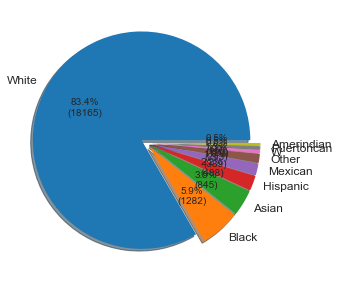

In [17]:
filter_value = 15
aux = pd.DataFrame(X["race"].value_counts())
aux2 = pd.DataFrame(
    data={"race": aux[aux.race < filter_value].sum()[0]}, index=["Minor Groups"]
)
aux = aux.append(aux2)
aux = aux[aux.race >= filter_value]


def func(pct, allvals):
    absolute = int(np.round(pct / 100.0 * np.sum(allvals)))
    return "{:.1f}%\n({:d})".format(pct, absolute)


colors = sns.color_palette("pastel")[0 : aux.shape[0]]


# create pie chart
plt.figure()
explode = (0.05,) * aux.shape[0]

plt.pie(
    aux.race.values,
    labels=aux.index,
    autopct=lambda pct: func(pct, aux.race.values),
    shadow=True,
    explode=explode,
)
plt.savefig('images/lawPie.eps',format='eps')
plt.show()

In [18]:
X = df.drop(columns=['Score'])
y = df[["Score"]]

In [19]:
for col in X.columns:
    print(X[col].value_counts())

White          18165
Black           1282
Asian            845
Hispanic         488
Mexican          389
Other            293
W                120
Puertorican      110
Amerindian        99
Name: race, dtype: int64
Female    12254
Male       9537
Name: sex, dtype: int64
37.0    1568
39.0    1499
40.0    1429
36.0    1424
38.0    1360
        ... 
21.3       1
21.7       1
12.0       1
14.0       1
38.3       1
Name: LSAT, Length: 116, dtype: int64
3.4    1946
3.2    1931
3.3    1921
3.1    1873
3.5    1860
3.6    1687
3.0    1663
3.7    1429
2.9    1374
2.8    1048
3.8    1013
2.7     865
3.9     728
2.6     669
2.5     499
2.4     374
4.0     365
2.3     215
2.2     136
2.1     100
2.0      42
1.9      20
4.1      15
1.8       7
1.7       4
4.2       3
0.0       2
1.5       1
1.6       1
Name: UGPA, dtype: int64
NE    4302
GL    3822
FW    2904
SE    2651
MS    2346
SC    2251
Mt    1147
NG    1133
MW    1071
NW     163
PO       1
Name: region_first, dtype: int64


In [20]:
for col in X.columns:
    print(len(X[col].unique()))

9
2
116
29
11


In [21]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.75, random_state=42)

In [22]:
X_tr.shape

(5447, 5)

In [23]:
X_te.shape

(16344, 5)

In [24]:
def fit_predict(modelo, enc, data, target, test):
    pipe = Pipeline([("encoder", enc), ("model", modelo)])
    pipe.fit(data, target)
    return pipe.predict(test)


def auc_group(model, data, y_true, dicc, group: str = "", min_samples: int = 20):

    aux = data.copy()
    aux["target"] = y_true
    cats = aux[group].value_counts()
    cats = cats[cats > min_samples].index.tolist()
    cats = cats + ["all"]

    if len(dicc) == 0:
        dicc = defaultdict(list, {k: [] for k in cats})

    for cat in cats:
        if cat != "all":
            aux2 = aux[aux[group] == cat]
            preds = model.predict_proba(aux2.drop(columns="target"))[:, 1]
            truth = aux2["target"]
            dicc[cat].append(roc_auc_score(truth, preds))
        elif cat == "all":
            dicc[cat].append(roc_auc_score(y_true, model.predict_proba(data)[:, 1]))
        else:
            pass

    return dicc

In [25]:
def explain(xgb: bool = True):
    """
    Provide a SHAP explanation by fitting MEstimate and GBDT
    """
    if xgb:
        pipe = Pipeline(
            [("encoder", MEstimateEncoder()), ("model", GradientBoostingClassifier())]
        )
        pipe.fit(X_tr, y_tr)
        explainer = shap.Explainer(pipe[1])
        shap_values = explainer(pipe[:-1].transform(X_tr))
        shap.plots.beeswarm(shap_values)
        return pd.DataFrame(np.abs(shap_values.values), columns=X_tr.columns).sum()
    else:
        pipe = Pipeline(
            [("encoder", MEstimateEncoder()), ("model", LogisticRegression())]
        )
        pipe.fit(X_tr, y_tr)
        coefficients = pd.concat(
            [pd.DataFrame(X_tr.columns), pd.DataFrame(np.transpose(pipe[1].coef_))],
            axis=1,
        )
        coefficients.columns = ["feat", "val"]

        return coefficients.sort_values(by="val", ascending=False)

In [26]:
def calculate_cm(true, preds):
    # Obtain the confusion matrix
    cm = confusion_matrix(preds, true)

    #  https://stackoverflow.com/questions/31324218/scikit-learn-how-to-obtain-true-positive-true-negative-false-positive-and-fal
    FP = cm.sum(axis=0) - np.diag(cm)
    FN = cm.sum(axis=1) - np.diag(cm)
    TP = np.diag(cm)
    TN = cm.sum() - (FP + FN + TP)

    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP / (TP + FN)
    # Specificity or true negative rate
    TNR = TN / (TN + FP)
    # Precision or positive predictive value
    PPV = TP / (TP + FP)
    # Negative predictive value
    NPV = TN / (TN + FN)
    # Fall out or false positive rate
    FPR = FP / (FP + TN)
    # False negative rate
    FNR = FN / (TP + FN)
    # False discovery rate
    FDR = FP / (TP + FP)

    # Overall accuracy
    ACC = (TP + TN) / (TP + FP + FN + TN)

    ##########
    ## I AM NOT SURE ABOUT THIS 0 INDEX
    ###########
    return TPR[0]

In [27]:
def metric_calculator(
    modelo, data: pd.DataFrame, truth: pd.DataFrame, col: str, group1: str, group2: str
):
    aux = data.copy()
    aux["target"] = truth

    # Filter the data
    g1 = data[data[col] == group1]
    g2 = data[data[col] == group2]

    # Filter the ground truth
    g1_true = aux[aux[col] == group1].target
    g2_true = aux[aux[col] == group2].target

    # Do predictions
    p1 = modelo.predict(g1)
    p2 = modelo.predict(g2)

    # Extract metrics for each group
    res1 = calculate_cm(p1, g1_true)
    res2 = calculate_cm(p2, g2_true)
    return res1 - res2

In [28]:
m = Pipeline([('enc',OneHotEncoder()),('model',LogisticRegression())])
m.fit(X,y)

Pipeline(steps=[('enc', OneHotEncoder(cols=['race', 'sex', 'region_first'])),
                ('model', LogisticRegression())])

In [29]:
df

,race,sex,LSAT,UGPA,region_first,Score
0,White,Male,39.0,3.1,GL,0
1,White,Male,36.0,3.0,GL,1
2,White,Female,30.0,3.1,MS,0
3,Hispanic,Female,39.0,2.2,NE,1
4,White,Male,37.0,3.4,GL,0
...,...,...,...,...,...,...
21786,White,Female,33.0,4.0,SC,1
21787,White,Male,38.0,3.7,SC,0
21788,White,Male,36.0,4.0,SC,1
21789,White,Female,31.0,2.9,SC,1


In [30]:
res = {}
for cat,num in X['race'].value_counts().items():
    COL = "race"
    GROUP1 = "White"
    GROUP2 = cat
    res[cat] = [metric_calculator(modelo=m,data = X, truth = y,col=COL,group1=GROUP1,group2 =GROUP2),num]
    

In [31]:
res = pd.DataFrame(res).T

res.columns=['fairness','items']

res['items']= res['items'].astype(int)

In [32]:
res.head(30)

,fairness,items
White,0.000000,18165
Black,-0.772450,1282
Asian,-0.738400,845
Hispanic,-0.705358,488
Mexican,-0.768866,389
Other,-0.535271,293
W,-0.772450,120
Puertorican,-0.772450,110
Amerindian,-0.772450,99


In [33]:
def plot_rolling(data, roll_mean: int = 5, roll_std: int = 20):

    aux = data.rolling(roll_mean).mean().dropna()
    stand = data.rolling(roll_std).quantile(0.05, interpolation="lower").dropna()
    plt.figure()
    for col in data.columns:
        plt.plot(aux[col], label=col)
        # plt.fill_between(aux.index,(aux[col] - stand[col]),(aux[col] + stand[col]),# color="b",alpha=0.1,)
    plt.legend()
    plt.show()

In [34]:
def scale_output(data):
    return pd.DataFrame(
        StandardScaler().fit_transform(data), columns=data.columns, index=data.index
    )

# Experiment

In [35]:
def fair_encoder(model, param: list, enc: str = "mestimate", un_regularize: list = []):
    auc = {}
    metrica = []
    auc_tot = []

    allowed_enc = [
        "mestimate",
        "targetenc",
        "leaveoneout",
        "ohe",
        "woe",
        "james",
        "catboost",
    ]
    assert (
        enc in allowed_enc
    ), "Encoder not available or check for spelling mistakes: {}".format(allowed_enc)

    cols_enc = set(X_tr.columns) - set(un_regularize)

    for m in tqdm(param):
        if enc == "mestimate":
            encoder = Pipeline(
                [
                    ("reg", MEstimateEncoder(m=m, cols=cols_enc)),
                    ("unreg", MEstimateEncoder(m=0, cols=un_regularize)),
                ]
            )
        elif enc == "targetenc":
            encoder = TargetEncoder(smoothing=m)
        elif enc == "leaveoneout":
            encoder = Pipeline(
                [
                    ("reg", LeaveOneOutEncoder(sigma=m, cols=cols_enc)),
                    ("unreg", LeaveOneOutEncoder(sigma=0, cols=un_regularize)),
                ]
            )
        elif enc == "ohe":
            encoder = OneHotEncoder(handle_missing=-1)
        elif enc == "woe":
            encoder = WOEEncoder(randomized=True, sigma=m)
        elif enc == "james":
            encoder = JamesSteinEncoder(randomized=True, sigma=m)
        elif enc == "catboost":
            encoder = Pipeline(
                [
                    ("reg", CatBoostEncoder(a=1, sigma=m, cols=cols_enc)),
                    ("unreg", CatBoostEncoder(a=1, sigma=0, cols=un_regularize)),
                ]
            ) 

        pipe = Pipeline([("encoder", encoder), ("model", model)])
        pipe.fit(X_tr, y_tr)
        preds = pipe.predict(X_te)

        metrica.append(
            metric_calculator(
                modelo=pipe,
                data=X_tr,
                truth=y_tr,
                col=COL,
                group1=GROUP1,
                group2=GROUP2,
            )
        )
        auc = auc_group(model=pipe, data=X_te, y_true=y_te, dicc=auc, group=COL)
        auc_tot.append(roc_auc_score(y_te, pipe.predict_proba(X_te)[:, 1]))

    # Results formatting
    res = pd.DataFrame(index=param)
    res["fairness_metric"] = metrica
    res["auc_tot"] = auc_tot
    res["auc_" + GROUP1] = auc[GROUP1]
    res["auc_" + GROUP2] = auc[GROUP2]

    return res

In [36]:
# Experiment parameters
COL = "race"
GROUP1 = "White"
GROUP2 = "W"

In [37]:
cols_enc = ['region_first']
cols_enc = []

In [38]:
# normal OHE 0.654

In [39]:
## LR
one_hot1 = fair_encoder(model=LogisticRegression(), enc="ohe", param=[0])

PARAM = np.linspace(0, 1, 100)
gaus1 = fair_encoder(model=LogisticRegression(), enc="catboost", param=PARAM,un_regularize=cols_enc)
PARAM = np.linspace(0, 10000, 100)
smooth1 = fair_encoder(model=LogisticRegression(), enc="mestimate", param=PARAM,un_regularize=cols_enc)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [40]:

## DT
one_hot2 = fair_encoder(model=DecisionTreeClassifier(max_depth=5), enc="ohe", param=[0])
PARAM = np.linspace(0, 1, 50)
gaus2 = fair_encoder(model=DecisionTreeClassifier(max_depth=5), enc="catboost", param=PARAM,un_regularize=cols_enc)
PARAM = np.linspace(0, 10000, 50)
smooth2 = fair_encoder(model=DecisionTreeClassifier(max_depth=5), enc="mestimate", param=PARAM,un_regularize=cols_enc)
## GBDT
one_hot3 = fair_encoder(model=GradientBoostingClassifier(), enc="ohe", param=[0])

PARAM = np.linspace(0, 1, 50)
gaus3 = fair_encoder(model=GradientBoostingClassifier(), enc="catboost", param=PARAM,un_regularize=cols_enc)
PARAM = np.linspace(0, 10000, 50)
smooth3 = fair_encoder(model=GradientBoostingClassifier(), enc="mestimate", param=PARAM,un_regularize=cols_enc)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

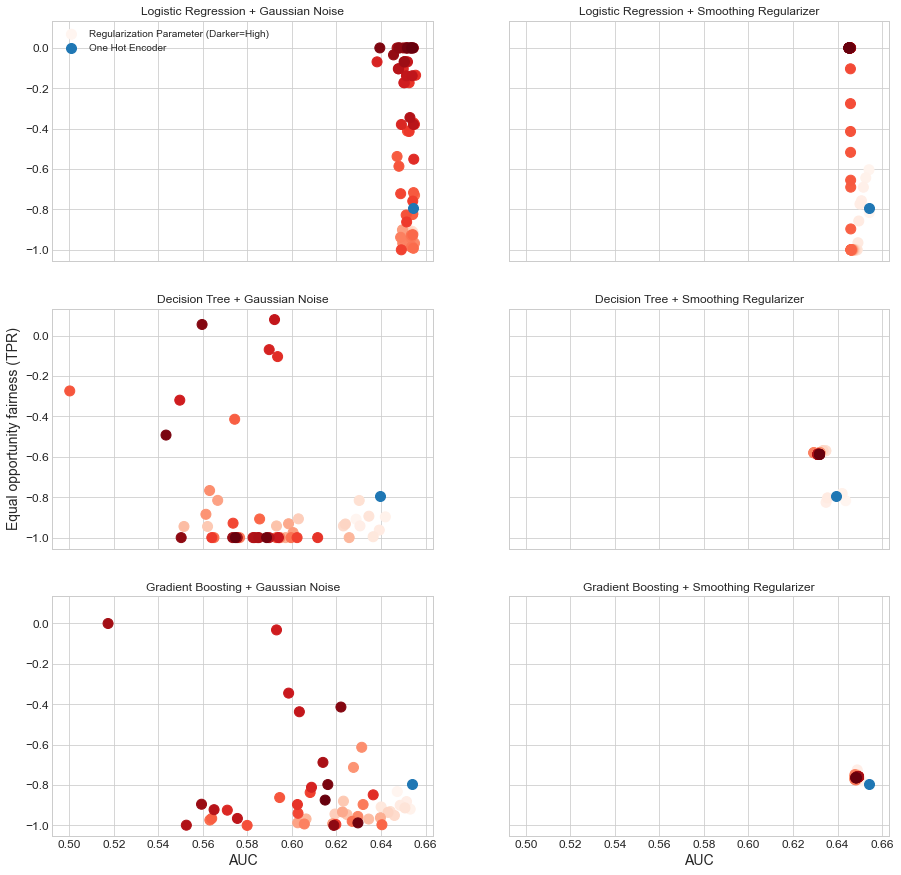

In [41]:
fig, axs = plt.subplots(3, 2, figsize=(15, 15), sharex=True, sharey=True)

#LR
axs[0, 0].set_title("Logistic Regression + Gaussian Noise")
#axs[0, 0].axis(xmin=0.5,xmax=13.5)
axs[0, 0].scatter(
    gaus1["auc_tot"].values,
    gaus1["fairness_metric"].values,
    s=100,
    c=gaus1.index.values,
    cmap="Reds",
    label="Regularization Parameter (Darker=High)",
)
axs[0, 0].scatter(
    y=one_hot1.fairness_metric, x=one_hot1.auc_tot, s=100, label="One Hot Encoder"
)
axs[0,0].legend()
axs[0, 1].set_title("Logistic Regression + Smoothing Regularizer")
axs[0, 1].scatter(
    smooth1["auc_tot"].values,
    smooth1["fairness_metric"].values,
    s=100,
    c=smooth1.index.values,
    cmap="Reds",
    label="Regularization Parameter (Darker=High)",
)
axs[0, 1].scatter(
    y=one_hot1.fairness_metric, x=one_hot1.auc_tot, s=100, label="One Hot Encoder"
)



## DT
axs[1, 0].set_title("Decision Tree + Gaussian Noise")
axs[1, 0].set(ylabel="Equal opportunity fairness (TPR)")
axs[1, 0].scatter(
    gaus2["auc_tot"].values,
    gaus2["fairness_metric"].values,
    s=100,
    c=gaus2.index.values,
    cmap="Reds",
    label="Regularization Parameter (Darker=High)",
)
axs[1, 0].scatter(
    y=one_hot2.fairness_metric, x=one_hot2.auc_tot, s=100, label="One Hot Encoder"
)

axs[1, 1].set_title("Decision Tree + Smoothing Regularizer")
axs[1, 1].scatter(
    smooth2["auc_tot"].values,
    smooth2["fairness_metric"].values,
    s=100,
    c=smooth2.index.values,
    cmap="Reds",
    label="Regularization Parameter (Darker=High)",
)
axs[1, 1].scatter(
    y=one_hot2.fairness_metric, x=one_hot2.auc_tot, s=100, label="One Hot Encoder"
)

# GBDT
axs[2, 0].set_title("Gradient Boosting + Gaussian Noise")
axs[2, 0].set(xlabel="AUC")
axs[2, 0].scatter(
    gaus3["auc_tot"].values,
    gaus3["fairness_metric"].values,
    s=100,
    c=gaus3.index.values,
    cmap="Reds",
    label="Regularization Parameter (Darker=High)",
)
axs[2, 0].scatter(
    y=one_hot3.fairness_metric, x=one_hot3.auc_tot, s=100, label="One Hot Encoder"
)

axs[2, 1].set_title("Gradient Boosting + Smoothing Regularizer")
axs[2, 1].set(xlabel="AUC")
axs[2, 1].scatter(
    smooth3["auc_tot"].values,
    smooth3["fairness_metric"].values,
    s=100,
    c=smooth3.index.values,
    cmap="Reds",
    label="Regularization Parameter (Darker=High)",
)
axs[2, 1].scatter(
    y=one_hot3.fairness_metric, x=one_hot3.auc_tot, s=100, label="One Hot Encoder"
)

fig.savefig('images/encLawFull.eps',format='eps')
fig.show()

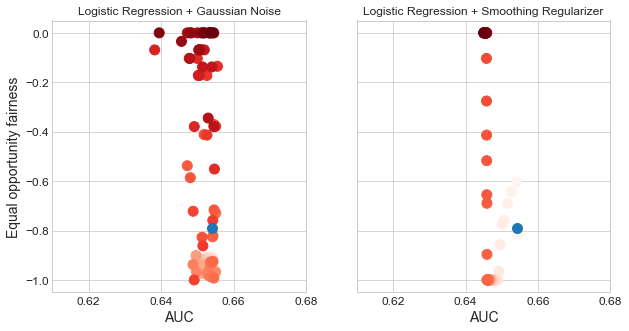

In [51]:
fig, axs = plt.subplots(1, 2,  sharex=True, sharey=True)
#LR
axs[0].axis(xmin=0.61,xmax=0.68)
axs[0].set_title("Logistic Regression + Gaussian Noise")
axs[0].scatter(
    gaus1["auc_tot"].values,
    gaus1["fairness_metric"].values,
    s=100,
    c=gaus1.index.values,
    cmap="Reds",
    label="Regularization Parameter (Darker=High)",
)
axs[0].scatter(
    y=one_hot1.fairness_metric, x=one_hot1.auc_tot, s=100, label="One Hot Encoder"
)
#axs[0].legend()

axs[0].set(xlabel="AUC")
axs[1].set(xlabel="AUC")
axs[0].set(ylabel="Equal opportunity fairness")


axs[1].set_title("Logistic Regression + Smoothing Regularizer")
axs[1].scatter(
    smooth1["auc_tot"].values,
    smooth1["fairness_metric"].values,
    s=100,
    c=smooth1.index.values,
    cmap="Reds",
    label="Regularization Parameter (Darker=High)",
)
axs[1].scatter(
    y=one_hot1.fairness_metric, x=one_hot1.auc_tot, s=100, label="One Hot Encoder"
)
fig.savefig('images/encLawLogRed.eps',format='eps')
fig.show()

In [43]:
one_hot1

,fairness_metric,auc_tot,auc_White,auc_W
0,-0.790584,0.654154,0.597969,0.402778


In [44]:
smooth1

,fairness_metric,auc_tot,auc_White,auc_W
0.000000,-0.815476,0.654263,0.598121,0.461538
101.010101,-0.603318,0.654118,0.598470,0.486111
202.020202,-0.643361,0.652665,0.596870,0.472222
303.030303,-0.689898,0.651602,0.595761,0.470085
404.040404,-0.756848,0.650738,0.594937,0.461538
...,...,...,...,...
9595.959596,0.000000,0.645104,0.587945,0.470085
9696.969697,0.000000,0.645088,0.587922,0.470085
9797.979798,0.000000,0.645500,0.588518,0.466880
9898.989899,0.000000,0.645064,0.587887,0.470085


In [45]:
one_hot1

,fairness_metric,auc_tot,auc_White,auc_W
0,-0.790584,0.654154,0.597969,0.402778


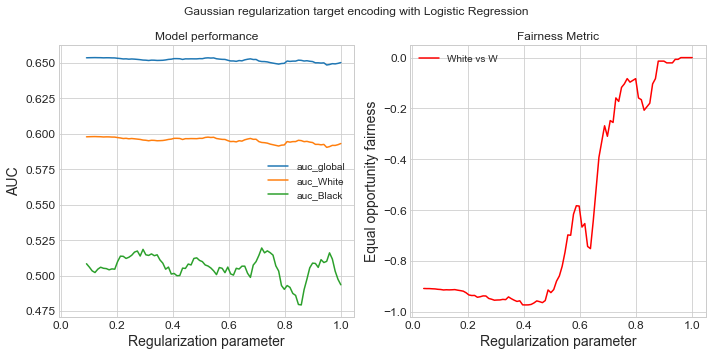

In [46]:
fig, axs = plt.subplots(1, 2,sharex=True)

gaus1.columns  = ['fairness_metric', 'auc_global', 'auc_White', 'auc_Black']
fig.suptitle("Gaussian regularization target encoding with Logistic Regression")
aux = (
    gaus1[["auc_global", "auc_White", "auc_Black"]]
    .rolling(10)
    .mean()
    .dropna()
)


for col in aux.columns:
    axs[0].plot(aux[col], label=col)
    # plt.fill_between(aux.index,(aux[col] - stand[col]),(aux[col] + stand[col]),# color="b",alpha=0.1,)
axs[0].legend()
axs[0].set_title("Model performance")
axs[0].set_ylabel("AUC")
axs[0].set_xlabel("Regularization parameter")

aux = gaus1[["fairness_metric"]].rolling(5).mean().dropna()

axs[1].plot(aux['fairness_metric'], label=GROUP1+' vs '+ GROUP2,color='r')

axs[1].legend()
axs[1].set_title("Fairness Metric")
axs[1].set_ylabel("Equal opportunity fairness")
axs[1].set_xlabel("Regularization parameter")
plt.tight_layout()
plt.savefig('images/LawHyperGaussian.eps',format='eps')
plt.show()

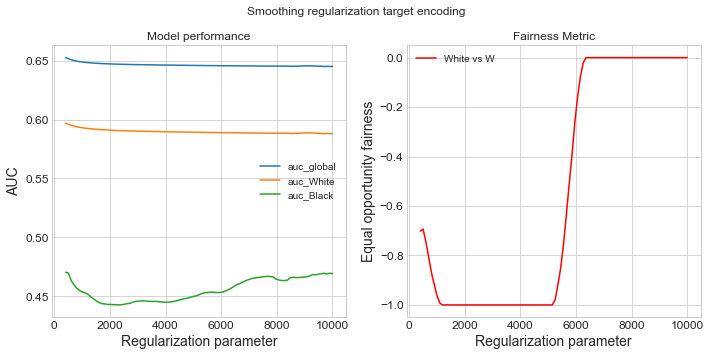

In [54]:
fig, axs = plt.subplots(1, 2,sharex=False)

smooth1.columns  = ['fairness_metric', 'auc_global', 'auc_White', 'auc_Black']
fig.suptitle("Smoothing regularization target encoding")
aux = (
    smooth1[["auc_global", "auc_White", "auc_Black"]]
    .rolling(5)
    .mean()
    .dropna()
)


for col in aux.columns:
    axs[0].plot(aux[col], label=col)
    # plt.fill_between(aux.index,(aux[col] - stand[col]),(aux[col] + stand[col]),# color="b",alpha=0.1,)
axs[0].legend()
axs[0].set_title("Model performance")
axs[0].set_ylabel("AUC")
axs[0].set_xlabel("Regularization parameter")

aux = smooth1[["fairness_metric"]].rolling(5).mean().dropna()

axs[1].plot(aux['fairness_metric'], label=GROUP1+' vs '+ GROUP2,color='r')

axs[1].legend()
axs[1].set_title("Fairness Metric")
axs[1].set_ylabel("Equal opportunity fairness")
axs[1].set_xlabel("Regularization parameter")
plt.tight_layout()
plt.savefig('images/LawHyperSmoothingRed.eps',format='eps')
plt.show()

In [48]:
kk

NameError: name 'kk' is not defined

In [ ]:
X.head(2)

In [ ]:
X.first_pf.hist()

In [ ]:
explain()